# Smart Distribution Systems (B-KUL-H00P3A) 
Prof. Geert Deconinck

This exercise session will familiarize you with basic concepts from machine learning and show you how these concepts can be used within power systems for forecasting.

You will learn to:
* set up a machine learning environment, using state-of-the-art tools, such as keras, tensorflow and theano in Python;
* implement and train a two-layer neural network using Keras;
* use this neural network to make prediction about the wholesale electricity price.


In [0]:
import pandas as pd
import numpy as np
#%matplotlib ipympl
import matplotlib.pyplot as plt
import time
import pickle
import datetime
import datetime as dt
import io
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import RepeatedKFold # import KFold
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

The next code snippet allow us to upload our data to Google Colab. The execution of the next two lines generate a widget window that you can use to browse your computer for the 4 csv files used in this exercise session: 'solar_20162017.csv', 'wind_20162017.csv', 'belpex_20162017.csv' and 'belpex_2011.csv'. Upload these files to the Google Colab environment. 

In [2]:
from google.colab import files
uploaded = files.upload()

Saving belpex_20162017.csv to belpex_20162017.csv
Saving solar_20162017.csv to solar_20162017.csv
Saving wind_20162017.csv to wind_20162017.csv


For more information on de pandas data frame see: http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html

In [0]:
start_date = dt.datetime(2016,1,1)
end_date = dt.datetime(2017,12,31)

First we'll import the csv with the solar data into pandas. Use the pandas documentation to figure out what each of lines do in the next piece of code.

In [0]:
df_solar = pd.read_csv('solar_20162017.csv', header=0)
df_solar = df_solar.rename(columns = {'Unnamed: 0':'time'})
df_solar['time'] = pd.to_datetime(df_solar['time'])
df_solar.set_index('time', inplace=True)


For now, we're only interested in the LoadFactor (actual solar power generated in Belgium).

In [400]:
df_solar = df_solar.LoadFactor
df_solar.head()

time
2016-01-01 00:00:00    0.0
2016-01-01 00:15:00    0.0
2016-01-01 00:30:00    0.0
2016-01-01 00:45:00    0.0
2016-01-01 01:00:00    0.0
Name: LoadFactor, dtype: float64

We do the same thing for the wind power data.

In [401]:
df_wind = pd.read_csv('wind_20162017.csv', header=0)
df_wind = df_wind.rename(columns = {'Unnamed: 0':'time'})
df_wind['time'] = pd.to_datetime(df_wind['time'])
df_wind.set_index('time', inplace=True)
df_wind = df_wind.LoadFactor
df_wind.head()

time
2016-01-01 00:00:00    0.47
2016-01-01 00:15:00    0.43
2016-01-01 00:30:00    0.41
2016-01-01 00:45:00    0.41
2016-01-01 01:00:00    0.40
Name: LoadFactor, dtype: float64

And for the Belgian day-ahead electricity prices>

In [402]:
df_belpex = pd.read_csv('belpex_20162017.csv', header=0)
df_belpex = df_belpex.rename(columns = {'Unnamed: 0':'time'})
df_belpex['time'] = pd.to_datetime(df_belpex['time'])
df_belpex.set_index('time', inplace=True)
df_belpex = df_belpex.price
df_belpex.head()

time
2016-01-01 00:00:00    23.86
2016-01-01 01:00:00    22.39
2016-01-01 02:00:00    20.59
2016-01-01 03:00:00    16.81
2016-01-01 04:00:00    17.41
Name: price, dtype: float64

Unfortunately, in real-life datasets, sometimes, certain data is missing. We can see this by trying to assign the price to a variable named 'p' and catching the error if no value is available.

In [403]:
dates = pd.date_range(start=start_date, end=end_date, freq='1H')
for d in dates:
    try:
        p = df_belpex.loc[d]
    except KeyError:
        print(d)

2016-03-27 02:00:00
2017-03-26 02:00:00


We will have to take assumptions of these values. In this case it makes sense to either assume they are the same as the previous hour or the next hour. Or, to take the average of both. In this case we will just assume the price is the same as the previous hour.

In [0]:
dates = pd.date_range(start=start_date, end=end_date, freq='1H')
for d in dates:
    try:
        p = df_belpex.loc[d]
    except KeyError:
        df_belpex.loc[d] = df_belpex.loc[d-dt.timedelta(hours=1)]
df_belpex = df_belpex.sort_index()
df_belpex = df_belpex[start_date:end_date]

Additionally the wind dataset has certain NaN (Not a Number) values. We don't want these in our dataset either. Therefore, we choose to fill the previous valid observation until the next valid one. <br>
Check for nan's in the wind dataset in the next cell!

In [0]:
df_wind =  df_wind.fillna(method='pad')

Moreover, the different datasets have different time granularities. Different options are possible to deal with this issue. Here we will use the smallest granularity. Solar and PV data are on a 15 minute basis. Therefore, we will also put the belpex data on a 15 minutes basis (the price of every quarter within an hour is just the price of that hour). <br>
Check the pandas 'resample' documentation here: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.resample.html

In [406]:
df_belpex = df_belpex.resample('15T').pad()
print(df_belpex[0:])

time
2016-01-01 00:00:00    23.86
2016-01-01 00:15:00    23.86
2016-01-01 00:30:00    23.86
2016-01-01 00:45:00    23.86
2016-01-01 01:00:00    22.39
                       ...  
2017-12-30 23:00:00    23.49
2017-12-30 23:15:00    23.49
2017-12-30 23:30:00    23.49
2017-12-30 23:45:00    23.49
2017-12-31 00:00:00    21.27
Freq: 15T, Name: price, Length: 70081, dtype: float64


Now we can all add them into one dataframe with 3 columns and a datetime index.

In [407]:
d = {'belpex': df_belpex.values.flatten(), 'solar': df_solar.values, 'wind': df_wind.values}
data = pd.DataFrame(index=df_belpex.index, data=d)
print (data)

                     belpex  solar  wind
time                                    
2016-01-01 00:00:00   23.86    0.0  0.47
2016-01-01 00:15:00   23.86    0.0  0.43
2016-01-01 00:30:00   23.86    0.0  0.41
2016-01-01 00:45:00   23.86    0.0  0.41
2016-01-01 01:00:00   22.39    0.0  0.40
...                     ...    ...   ...
2017-12-30 23:00:00   23.49    0.0  0.36
2017-12-30 23:15:00   23.49    0.0  0.39
2017-12-30 23:30:00   23.49    0.0  0.45
2017-12-30 23:45:00   23.49    0.0  0.45
2017-12-31 00:00:00   21.27    0.0  0.41

[70081 rows x 3 columns]


Usefull commands
* data.head(10) prints the first 10 samples
* data.tail(10) prints the last 10 samples
* data.$wind$ prints the collumn with label $wind$ 
* data.wind.plot plots the wind timeseries

# 1. Visualize the data

In [408]:
print(data.head(10))
print(data.tail(10))

                     belpex  solar  wind
time                                    
2016-01-01 00:00:00   23.86    0.0  0.47
2016-01-01 00:15:00   23.86    0.0  0.43
2016-01-01 00:30:00   23.86    0.0  0.41
2016-01-01 00:45:00   23.86    0.0  0.41
2016-01-01 01:00:00   22.39    0.0  0.40
2016-01-01 01:15:00   22.39    0.0  0.35
2016-01-01 01:30:00   22.39    0.0  0.33
2016-01-01 01:45:00   22.39    0.0  0.32
2016-01-01 02:00:00   20.59    0.0  0.26
2016-01-01 02:15:00   20.59    0.0  0.21
                     belpex  solar  wind
time                                    
2017-12-30 21:45:00   23.31    0.0  0.52
2017-12-30 22:00:00   24.34    0.0  0.50
2017-12-30 22:15:00   24.34    0.0  0.48
2017-12-30 22:30:00   24.34    0.0  0.42
2017-12-30 22:45:00   24.34    0.0  0.39
2017-12-30 23:00:00   23.49    0.0  0.36
2017-12-30 23:15:00   23.49    0.0  0.39
2017-12-30 23:30:00   23.49    0.0  0.45
2017-12-30 23:45:00   23.49    0.0  0.45
2017-12-31 00:00:00   21.27    0.0  0.41


Create a plot of the different collums using matplotlib.

Plotting with matplotlib.pyplot is very similar to plotting in matlab. Some key commands:
* <b>plt.figure()</b>: creates a new, blank figure. This changes the current graph and axis to the newly created ones. All commands applied hereafter will be applied to the new, current figure.
* <b>plt.show()</b>: show the figure. If you don't execute this command, no figure will show.
* For more commands, see http://matplotlib.org/users/pyplot_tutorial.html

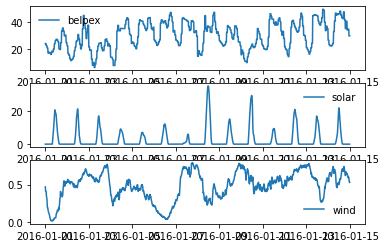

In [409]:
start = datetime.datetime(2016, 1, 1, 0, 0)
end = datetime.datetime(2016, 1, 14, 23, 45)

plt.figure()
plt.subplot(311)
plt.plot(data.belpex[start:end], label='belpex')
plt.legend(frameon=False)
plt.subplot(312)
plt.plot(data.solar[start:end], label='solar')
plt.legend(frameon=False)
plt.subplot(313)
plt.plot(data.wind[start:end], label='wind')
plt.legend(frameon=False)
plt.show()

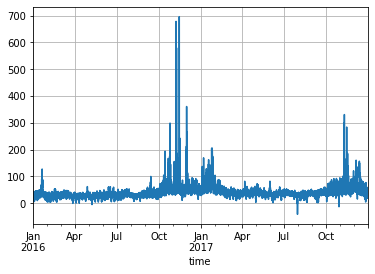

In [410]:
plt.figure()
data.belpex.plot(grid=True)
plt.show()

# 2. Clean the data by removing outliers

Outliers are mostly difficult, if not impossible, to predict. Therefore, we like to remove them. Moreover, sometimes these outliers are not even correct. 

As an example you can check out the belpex price of the year 2011.

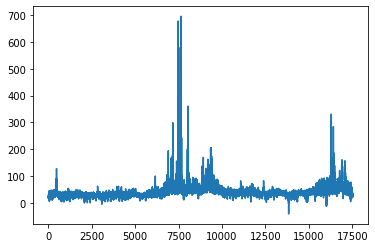

In [411]:
df = pd.read_csv('belpex_20162017.csv', header=0)
df.price.plot()

Read why this happened in this study of the CREG: http://www.creg.be/nl/publicaties/study-on-price-spike-on-belpex-dam-28-march-2011 .

Clue: Use a generic method from statistics that is independent of the timeseries

In [0]:
mean = data.belpex.mean()
std = data.belpex.std()
n_std = 5
data['belpex'][(data.belpex >= mean + n_std*std)] = mean + n_std*std 
data['belpex'][(data.belpex <= mean - n_std*std)] = mean + n_std*std 

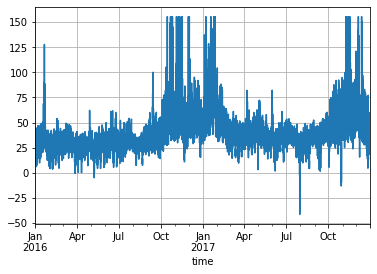

In [413]:
plt.figure()
data.belpex.plot(grid=True)
plt.show()

# 3. Create boxplot

It is always useful to get more insight in the data you are using.

Create a boxplot grouped by
* days in the week
* months
* hours
* years

http://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html

A pandas dataframe has a table like structure. The very first column in the table contains the indices, uniquely identifying each row in the table. These indices can be a set of integers, or like in this case, a set of timestamps, points in time when the specified data was realised.

'data.index' will return all timestamps of the dataset as an array. These timestamps have certain attributes available. For a reference, see:
http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DatetimeIndex.html

Below, attributes of the datetime indices are stored in a new column of the table. This allows us to create box plots grouped by these attributes, such as day of the week, hour, etc.

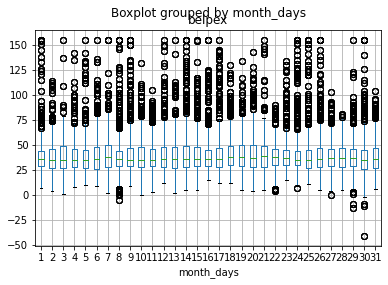

In [414]:
data['week_days']=data.index.weekday
data['month_days']=data.index.day
data['hours']=data.index.hour
data['months']=data.index.month
data['year'] = data.index.year

data.boxplot(column='belpex', by='month_days')

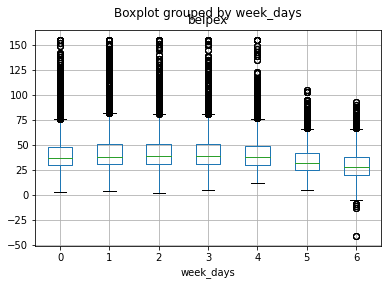

In [415]:
data.boxplot(column='belpex', by='week_days')

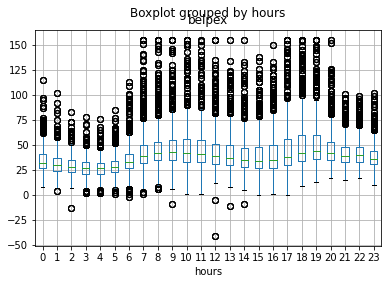

In [416]:
data.boxplot(column='belpex', by='hours')

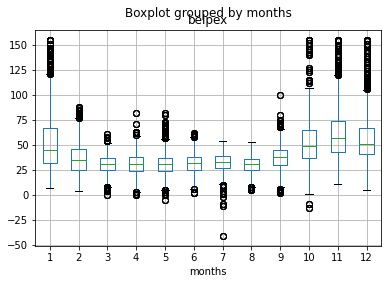

In [417]:
data.boxplot(column='belpex', by='months')

Finally, <b>give it a try yourself</b>. Make a boxplot grouped by the year.

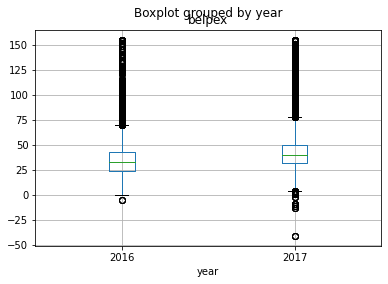

In [418]:
data.boxplot(column='belpex', by= 'year')

# 4. Check for randomness in the time series using an autocorrelation plot

This is done by computing autocorrelations for data values at varying time lags. If time series is random, such autocorrelations should be near zero for any and all time-lag separations. If time series is non-random then one or more of the autocorrelations will be significantly non-zero. 

The autocorrelation is the correlation of a timeseries with a delayed copy of itself and is given by:
\begin{equation}
R(\tau) = \frac{E[(X_{t}-\mu)(X_{t+\tau}-\mu)]}{\sigma^2}
\end{equation}
where $X_t$ is the time series and $\tau$ is the time-lag.

How to make an autocorrelation plot using pandas in python:
http://pandas.pydata.org/pandas-docs/stable/visualization.html#visualization-autocorrelation

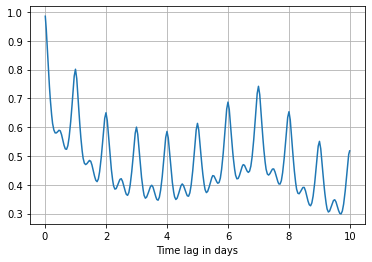

In [419]:
# Autocorrelation
lags = np.arange(1, 96*10)
acors = []
for lag in lags:
    acors.append(data.belpex.autocorr(lag))
plt.figure()
plt.plot(lags/4/24.0, acors)
plt.xlabel('Time lag in days')
plt.grid(True)

# 5. Create a scatter matrix 

<b>Why use a scatter plot matrix?</b>

You have three types of data:
* electricity price $p$
* solar generation $s$
* wind generation $w$

For certain moments in time, we have three data points. This means we could think of our dataset as points in a four-dimensional space:
$$\begin{Bmatrix}t\\p\\s\\w\end{Bmatrix}$$

Unless you can think of your dataset in four dimensions, let's make it a bit easier. First, we strip away the time dimension. This leaves us with a more dense three-dimensional space containing all our samples. Still, we don't like to think in three dimensions. So let's just try all possible pairs of the remaining dimensions.

We visualize each pair with a scatter plot. A scatter plot is simply a graph with dots, which are not connected. Hence, we get a matrix of scatter plots, a scatter matrix.

We do all of this to explore our dataset, and find relationships in our data. For example, if the 'price vs solar generation' scatter plot shows dots centered around a straight line, then we can conclude that there is a linear relationship between price and solar generation. This is something that we could exploit later on, when we make our model. 

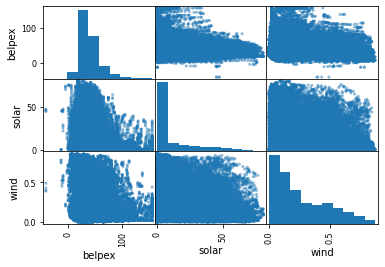

In [420]:
import pandas as pd
a = pd.plotting.scatter_matrix(data[['belpex', 'solar', 'wind']])

If the diagonal is not what you would expect, then you are right. For more information, see

http://stackoverflow.com/questions/26360759/understanding-the-diagonal-in-pandas-scatter-matrix-plot

# 6. Linear regression

Metric to define the quality of the foreceast

In [0]:
def get_accuracy(x, y):
    return np.mean(np.abs(x - y))/np.mean(x)

In this section, we will use the scikit learn toolbox. For more information, see
* [API reference](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.model_selection)
* [Tutorials](http://scikit-learn.org/stable/tutorial/index.html)

In [424]:
from sklearn.linear_model import LinearRegression, Ridge
model = LinearRegression(normalize=True)
lags = [24*4] + list(range(96*7, 96*35, 96))+[24*7]
features = ['wind', 'solar']
print(lags)
len(lags)

[96, 672, 768, 864, 960, 1056, 1152, 1248, 1344, 1440, 1536, 1632, 1728, 1824, 1920, 2016, 2112, 2208, 2304, 2400, 2496, 2592, 2688, 2784, 2880, 2976, 3072, 3168, 3264, 168]


30

In [425]:
index = data.index 
for lag in lags:
    data['belpex_lag_{}'.format(lag)] = data.belpex.shift(lag)
    features.append('belpex_lag_{}'.format(lag))
data['day_in_year'] = data.index.dayofyear
#data = data.loc[index, :]
data = data.dropna()

X = data[features]
y = data.belpex

cv = KFold(n_splits=10, shuffle=False)
data['belpex_pred'] = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)

print(get_accuracy(data.belpex, data.belpex_pred))



0.15718244237883172


In [426]:
print(features)

['wind', 'solar', 'belpex_lag_96', 'belpex_lag_672', 'belpex_lag_768', 'belpex_lag_864', 'belpex_lag_960', 'belpex_lag_1056', 'belpex_lag_1152', 'belpex_lag_1248', 'belpex_lag_1344', 'belpex_lag_1440', 'belpex_lag_1536', 'belpex_lag_1632', 'belpex_lag_1728', 'belpex_lag_1824', 'belpex_lag_1920', 'belpex_lag_2016', 'belpex_lag_2112', 'belpex_lag_2208', 'belpex_lag_2304', 'belpex_lag_2400', 'belpex_lag_2496', 'belpex_lag_2592', 'belpex_lag_2688', 'belpex_lag_2784', 'belpex_lag_2880', 'belpex_lag_2976', 'belpex_lag_3072', 'belpex_lag_3168', 'belpex_lag_3264', 'belpex_lag_168']


In [427]:
print(X.belpex_lag_96)

time
2016-02-04 00:00:00    17.59
2016-02-04 00:15:00    17.59
2016-02-04 00:30:00    17.59
2016-02-04 00:45:00    17.59
2016-02-04 01:00:00    13.34
                       ...  
2017-12-30 23:00:00    40.66
2017-12-30 23:15:00    40.66
2017-12-30 23:30:00    40.66
2017-12-30 23:45:00    40.66
2017-12-31 00:00:00    23.10
Freq: 15T, Name: belpex_lag_96, Length: 66817, dtype: float64


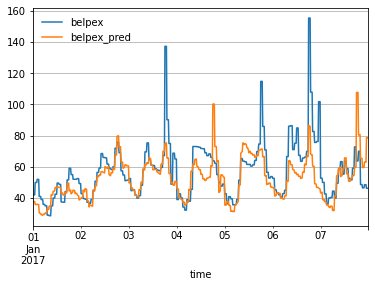

In [428]:
start = datetime.datetime(2017, 1, 1, 0, 0)
end = datetime.datetime(2017, 1, 7, 23, 45)

plt.figure()
data.belpex[start:end].plot(grid=True)
data.belpex_pred[start:end].plot(grid=True)
plt.legend(frameon=False,loc=2)
plt.show()

# 7. Neural network (a naive implementation)

In [0]:
import os

In [430]:
%tensorflow_version 1.x

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop, SGD

Create input and output training data. <br>
We will just predict the next day, based on the previous day.

In [0]:
n_hours = 24
start = datetime.datetime(2017, 1, 1, 0, 0)
end = datetime.datetime(2017, 12, 29, 23, 45)
X = data['belpex'][start:end].resample('1H').mean().values.reshape(-1, n_hours)
X_wind = data['wind'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_solar = data['solar'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_lag = data['belpex_lag_96'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_lag1 = data['belpex_lag_168'][start:end].resample('24H').mean().values.reshape(-1, 1)
#X_lag2 = data['belpex_lag_672'][start:end].resample('24H').mean().values.reshape(-1, 1)
#X_lag3 = data['belpex_lag_768'][start:end].resample('24H').mean().values.reshape(-1, 1)




X = np.hstack((X,X_wind))
X = np.hstack((X,X_solar))
X = np.hstack((X,X_lag))
X = np.hstack((X,X_lag1))
#X = np.hstack((X,X_lag2))
#X = np.hstack((X,X_lag3))

start = datetime.datetime(2017, 1, 2, 0, 0)
end = datetime.datetime(2017, 12, 30, 23, 45)
Y = data['belpex'][start:end].resample('1H').mean().values.reshape(-1, n_hours)

In [433]:
print(data['belpex'][start:end].resample('1H').mean().shape)

(8712,)


In [434]:
print('input_features ' + str(X.shape))
print('target dimensions ' + str(Y.shape))

input_features (363, 28)
target dimensions (363, 24)


Create neural network with one hidden layer

In [0]:
from sklearn.model_selection import KFold # import KFold
from sklearn.model_selection import RepeatedKFold # import KFold
from keras.callbacks import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

import tensorflow as tf
import keras



neurons = [28, 100, 24]
activation_functions = ['relu', 'linear', 'selu']

model = Sequential()
model.add(Dense(neurons[0], input_dim=X.shape[1], activation=activation_functions[0]))

model.add(Dense(neurons[1], activation=activation_functions[2]))
model.add (Dense(neurons[1],activation=activation_functions[2]))
model.add (Dense(neurons[1],activation=activation_functions[2]))
model.add (Dense(neurons[1],activation=activation_functions[2]))
model.add (Dense(neurons[1],activation=activation_functions[2]))
model.add (Dense(neurons[1],activation=activation_functions[2]))
model.add (Dense(neurons[2],activation=activation_functions[1]))

    
rprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model.compile(loss='mean_squared_error', optimizer=rprop)

In [436]:
output_training = model.fit(X, Y, epochs=2500, batch_size=32, verbose=0)
mse = output_training.history['loss'][-1]
print('- mse is %.4f' % mse + ' @ ' + str(len(output_training.history['loss'])))

- mse is 1.7021 @ 2500


In [437]:
predict_nn = model.predict(X)

print(get_accuracy(Y.flatten(), predict_nn.flatten()))


0.019831234888826866


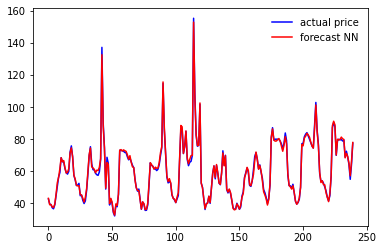

In [438]:
# Plots
plt.figure()
plt.plot(Y[:10,:].flatten(), color='blue', label='actual price')
plt.plot(predict_nn[:10,:].flatten(), color='red', label='forecast NN')
plt.legend(frameon=False)
plt.show()

# 8. Assignment: Improve the naive implementation in Step 7


* Create test and validation set
    * https://en.wikipedia.org/wiki/Test_set
    * http://stats.stackexchange.com/questions/19048/what-is-the-difference-between-test-set-and-validation-set
* Add additional features
    * same day of the previous week (see autocorrelation plot)
    * use a wind and solar forecast as an additional feature (assume you can make perfect forecasts)
    * Use EliaTotalLoad from datafetcher
    * Are there other features that have an influence on the price and thus may affect prediction performance
* Tune the structure of the neural network (use grid search)
    * number of layers
        * http://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
    * different activation functions
        * https://en.wikipedia.org/wiki/Activation_function

Advice: read the documentation on https://keras.io/ for help

In [439]:
n_hours = 24
start = datetime.datetime(2017, 5, 19, 0, 0)
end = datetime.datetime(2017, 12, 26, 23, 45)


X_V = data['belpex'][start:end].resample('1H').mean().values.reshape(-1, n_hours)
X_wind = data['wind'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_solar = data['solar'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_lag = data['belpex_lag_168'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_lag1 = data['belpex_lag_96'][start:end].resample('24H').mean().values.reshape(-1, 1)
#X_lag2 = data['belpex_lag_672'][start:end].resample('24H').mean().values.reshape(-1, 1)

X_V = np.hstack((X_V,X_wind))
X_V = np.hstack((X_V,X_solar))
X_V = np.hstack((X_V,X_lag))
X_V = np.hstack((X_V,X_lag1))
#X_V = np.hstack((X_V,X_lag2))


start = datetime.datetime(2017, 5, 22, 0, 0)
end = datetime.datetime(2017, 12, 29, 23, 45)
Y_V = data['belpex'][start:end].resample('1H').mean().values.reshape(-1, n_hours)

#X_V = keras.backend.reshape(X_V, shape=(259, 24))

print('input_features ' + str(X_V.shape))
print('target dimensions ' + str(Y_V.shape))


input_features (222, 28)
target dimensions (222, 24)


In [440]:
kf = RepeatedKFold(n_splits=3, n_repeats=2, random_state=None) # Define the split - into 2 folds 
kf.get_n_splits(X_V) # returns the number of splitting iterations in the cross-validator
print(kf) 

RepeatedKFold(n_repeats=2, n_splits=3, random_state=None)


In [441]:
earlyStopping=EarlyStopping(monitor='val_loss', patience=500, verbose=0, mode='auto')

rprop = RMSprop(lr=0.001, rho=0.9, epsilon=1e-6)
model.compile(loss='mean_squared_error', optimizer=rprop)

for train_index, test_index in kf.split(X_V):
    output_test = model.fit(X_V[train_index], Y_V[train_index], epochs=2500, batch_size=24, verbose=0, callbacks=[earlyStopping])
    mse = output_test.history['loss'][-1]
    print('- mse is %.4f' % mse + ' @ ' + str(len(output_training.history['loss'])))

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


- mse is 0.5455 @ 2500
- mse is 1.2540 @ 2500
- mse is 0.3472 @ 2500
- mse is 0.1023 @ 2500
- mse is 0.1810 @ 2500
- mse is 0.1562 @ 2500


In [442]:
predict_nn = model.predict(X_V)

print(get_accuracy(Y_V.flatten(), predict_nn.flatten()))

0.054377080877419416


In [443]:
from sklearn.metrics import mean_squared_error

n_hours = 24
start = datetime.datetime(2017, 8, 1, 0, 0)
end = datetime.datetime(2017, 12, 29, 23, 45)
X_fin = data['belpex'][start:end].resample('1H').mean().values.reshape(-1, n_hours)

X_wind = data['wind'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_solar = data['solar'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_lag = data['belpex_lag_168'][start:end].resample('24H').mean().values.reshape(-1, 1)
X_lag1 = data['belpex_lag_96'][start:end].resample('24H').mean().values.reshape(-1, 1)
#X_lag2 = data['belpex_lag_672'][start:end].resample('24H').mean().values.reshape(-1, 1)

X_final = np.hstack((X_fin,X_wind))
X_final = np.hstack((X_final,X_solar))
X_final = np.hstack((X_final,X_lag))
X_final = np.hstack((X_final,X_lag1))
#X_final = np.hstack((X_final,X_lag2))

start = datetime.datetime(2017, 8, 2, 0, 0)
end = datetime.datetime(2017, 12, 30, 23, 45)
Y_final = data['belpex'][start:end].resample('1H').mean().values.reshape(-1, n_hours) 

predict_nn=model.predict(X_final)

print (predict_nn)
print (Y_final)




[[25.158554 23.756044 22.684422 ... 35.28962  34.88469  40.25549 ]
 [32.301785 25.521294 25.353285 ... 33.95291  33.86255  32.2762  ]
 [25.667028 20.521427 18.54187  ... 35.860012 35.860092 34.730843]
 ...
 [47.39087  47.17217  40.957245 ... 57.588203 51.580032 46.84002 ]
 [37.879562 35.627087 31.701996 ... 39.32412  38.228687 36.106766]
 [39.174416 38.167793 31.41945  ... 49.4517   50.83922  42.861843]]
[[27.62 26.59 26.2  ... 36.77 37.53 34.46]
 [28.1  26.47 24.76 ... 31.85 29.69 26.51]
 [25.   23.65 22.36 ... 34.93 34.96 39.93]
 ...
 [31.16 30.   28.1  ... 40.58 38.23 34.08]
 [34.08 35.77 43.77 ... 37.59 37.99 40.66]
 [23.1  23.37 22.55 ... 23.31 24.34 23.49]]


Plotting Predictions vs Original Data

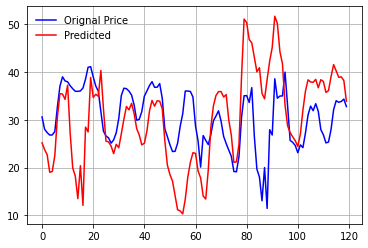

In [444]:
plt.figure()
plt.plot(X_fin[:5,:].flatten(), color='blue', label='Orignal Price')
plt.plot(predict_nn[:5,:].flatten(), color='red', label='Predicted')
plt.legend(frameon=False)
plt.grid()
plt.autoscale()
plt.show()

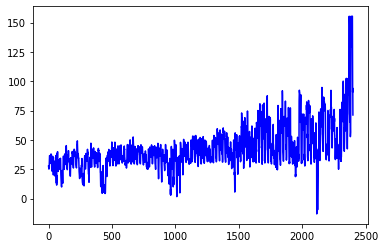

In [445]:
plt.figure()
plt.plot(Y_final[:100,:].flatten(), color='blue', label='previous price')

In [446]:
mean_squared_error(Y_final, predict_nn)

363.04864236417137

In [447]:
mean_squared_error(Y_final[:20,:], predict_nn[:20,:])
print('input_features ' + str(predict_nn.shape))

input_features (151, 24)


In [477]:

#Starting Date of the data-set in CSV file
start1 = dt.datetime(2018,1,1,0,0) 
#Ending Date of the data-set in CSV file
end1 = dt.datetime(2018,1,7,23,0)

import csv
from datetime import datetime

date_rng = pd.date_range(start='1/1/2018 00:00', end='1/08/2018 00:00', freq='H')

df = pd.DataFrame(date_rng, columns=['date'])
df_belpex1_prices = pd.read_csv('belpex_week_3.csv', header=0)
#print(df_belpex1_prices)
df['prices']=df_belpex1_prices
dfp=df.prices
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df = df.resample('15T').pad()
df = df.iloc[0:672,]
d11 = {'belpexa': df.values.flatten()}
data = pd.DataFrame(index=df.index, data=d11)
#print(data)
#Starting Date of the data-set in CSV file
start1 = dt.datetime(2018,1,1,0,0) 
#Ending Date of the data-set in CSV file
end1 = dt.datetime(2018,1,7,23,0)
a = data.belpexa[start1:end1].resample('1H').mean().values.reshape(-1, n_hours)
dfp=df.prices
#print(a)


date_rng = pd.date_range(start='1/1/2018 00:00', end='1/07/2018 23:45', freq='15T')
df12 = pd.DataFrame(date_rng, columns=['date'])
df_wind1_prices = pd.read_csv('wind_week_3.csv', header=0)
df_wind1_prices=df_wind1_prices.LoadFactor
df12['wind']=df_wind1_prices
df_wind1_prices = df_wind1_prices.iloc[0:672,]
df12['date'] = pd.to_datetime(df12['date'])
df12.set_index('date', inplace=True)
d12 = {'winda': df12.values.flatten()}
data12 = pd.DataFrame(index=df12.index, data=d12)
a12 = data12.winda[start1:end1].resample('24H').mean().values.reshape(-1, 1)
#print(a12)


date_rng = pd.date_range(start='1/1/2018 00:00', end='1/07/2018 23:45', freq='15T')
df13 = pd.DataFrame(date_rng, columns=['date'])
df_solar1_prices = pd.read_csv('solar_week_3.csv', header=0)
df_solar1_prices=df_solar1_prices.LoadFactor
df13['solar']=df_solar1_prices
df_solar1_prices = df_solar1_prices.iloc[0:672,]
df13['date'] = pd.to_datetime(df13['date'])
df13.set_index('date', inplace=True)
d13 = {'solara': df13.values.flatten()}
data13 = pd.DataFrame(index=df13.index, data=d13)
a13 = data13.solara[start1:end1].resample('24H').mean().values.reshape(-1, 1)
#print(a13)

Eval_input_data = np.hstack((a,a12))
Eval_input_data = np.hstack((Eval_input_data,a13))
print('input_features ' + str(Eval_input_data.shape))
#print(Eval_input_data)


input_features (7, 26)


In [478]:
lags = [24*4] + list(range(96*7, 96*35, 96))+[24*7]
print(lags)


index = data.index 
for lag in lags:
    data['belpexa_lag_{}'.format(lag)] = data.belpexa.shift(lag)
    features.append('belpexa_lag_{}'.format(lag))
data['day_in_year'] = data.index.dayofyear  
    
#print(data['belpexa_lag_168'][start1:end1])
data.fillna(data.mean(), inplace = True)
#print(data['belpexa_lag_672'][start1:end1])

[96, 672, 768, 864, 960, 1056, 1152, 1248, 1344, 1440, 1536, 1632, 1728, 1824, 1920, 2016, 2112, 2208, 2304, 2400, 2496, 2592, 2688, 2784, 2880, 2976, 3072, 3168, 3264, 168]


In [0]:

a14 = data['belpexa_lag_168'][start1:end1].resample('24H').mean().values.reshape(-1, 1)
a15 = data['belpexa_lag_96'][start1:end1].resample('24H').mean().values.reshape(-1, 1)
#a16 = data['belpexa_lag_672'][start1:end1].resample('24H').mean().values.reshape(-1, 1)


In [480]:
Eval_input_data = np.hstack((Eval_input_data,a14))
Eval_input_data = np.hstack((Eval_input_data,a15))
print('input_features ' + str(Eval_input_data.shape))

input_features (7, 28)


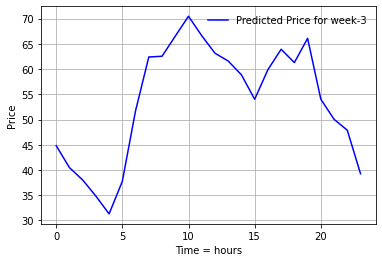

In [481]:
week_one_prediction=model.predict(Eval_input_data)

plt.figure()
plt.plot(week_one_prediction[0,:].flatten(), color='blue', label='Predicted Price for week-3')
plt.legend(frameon=False)
plt.grid()
plt.xlabel('Time = hours')
plt.ylabel('Price')
plt.show()

In [463]:
prediction1 = week_one_prediction[0,:]
print(prediction1[0:24])

[44.825333 40.47489  38.024258 34.822426 31.28862  37.751812 51.74096
 62.38795  62.53659  66.51772  70.465126 66.60796  63.140186 61.5928
 58.85363  54.01252  59.867878 63.91673  61.282272 66.08425  54.01911
 50.04195  47.872257 39.254253]


In [388]:
from pandas import DataFrame
df_export = pd.DataFrame(prediction1)
print(df_export)

            0
0   40.099270
1   34.947357
2   32.616280
3   28.386057
4   28.463263
5   34.112072
6   45.135216
7   56.479237
8   56.201870
9   59.901581
10  60.754589
11  57.744640
12  56.149467
13  55.722240
14  50.962624
15  48.931282
16  45.848824
17  62.593632
18  79.258881
19  83.750938
20  63.413368
21  53.865330
22  51.978878
23  47.352432


In [0]:
export_csv = df_export.to_csv (r'C:\Users\haider\Desktop\pred3.csv', mode='a', index = None, header=False)